# Build Target Model

Here we work to expand our on target rules to include information about the target site.
We consider three feature classes when building this model:

1. Position within a gene
  1. Guide orientation relative to the direction of transcription
  2. Distance to the end of the CDS
  3. Distance to the start of the CDS
  4. Percent of CDS
2. Amino acid information:
  1. Position independent one-mers
  2. "" two-mers
  3. Position dependent one-mers
  4. "" two-mers
3. Conservation:
  1. Of entire width
  2. Position dependent conservation one-mers
  3. "" two-mers

In [1]:
import pandas as pd
from datasets import dataset_list
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import clone
import joblib
import sglearn
import seaborn as sns
from tqdm import tqdm
from lightgbm import LGBMRegressor

from core import get_predictive_performance, plot_pearson_heatmap, plot_relative_performance

In [2]:
def featurize_target(df, features):
    """Featurize sgRNAs by their CDS target site.

    :param df: DataFrame, has columns: 'sgRNA Context Sequence', 'Target Cut Length', 'Target Cut %', 'Target Total Length'
    :param features: list
    :return:
    """
    feature_df_list = []
    if 'position' in features:
        position_df = df[['Target Cut Length', 'Target Cut %']].copy()
        position_df = position_df.rename(columns={'Target Cut Length': 'dist. from start',
                                                  'Target Cut %': 'dist. percent'})
        position_df['sense'] = df['Orientation'] == 'sense'
        position_df['dist. from end'] = df['Target Total Length'] - df['Target Cut Length']
        feature_df_list.append(position_df)
    feature_df = pd.concat(feature_df_list, axis=1)
    feature_df = feature_df.set_index(df['sgRNA Context Sequence'])
    return feature_df


def train_test_model(train_df, features, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from sglearn.featurize_guides
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    # TODO - modify featurization
    X_train = featurize_target(train_df, features)
    y_train = train_df['Residual Activity']
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def get_fold_predictions(fold, fold_df,
                         base_model=LGBMRegressor(random_state=7, n_jobs=8),
                         features=None, model_name=None):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param features: list
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    test_df = fold_df.query('train == False').reset_index(drop=True)
    # TODO - featurize
    X_test = featurize_target(test_df, features)
    test_prediction_list = []
    model = clone(base_model)
    if model_name is None:
        model_name = ' + '.join(features)
    dataset_test_predictions = train_test_model(train_df, features, model_name, fold,
                                                model, test_df, X_test)
    # return a list of length of one to combine with other training runs
    test_prediction_list.append(dataset_test_predictions)
    return test_prediction_list

## Reading Data

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
seq_model = joblib.load('../models/RuleSet3.pkl')

## Loading Datasets

In [4]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.get_sgrnas()


## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

We define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [5]:
sg_df_list = []
for ds in tqdm(train_data_list):
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    design_df = ds.get_designs()
    sg_df = sg_df.merge(design_df, how='inner',
                        on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


Context sequences with multiple targets: 0


In [6]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))

### Calculating Residuals

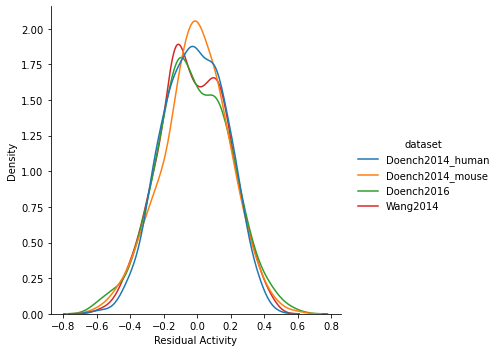

In [7]:
sg_df_class_groups['sgRNA Activity'] = (sg_df_class_groups.groupby('dataset')
                                        ['sgRNA Activity']
                                        .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_class_groups['sgRNA Context Sequence'])
sg_df_class_groups['Rule Set 3'] = seq_model.predict(seq_X)
sg_df_class_groups['Residual Activity'] = sg_df_class_groups['sgRNA Activity'] - sg_df_class_groups['Rule Set 3']
sns.displot(data=sg_df_class_groups, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False)

We see again that the Doench Human and Mouse data do not appear in every train/test fold due to the relatively
small number of genes.

In [8]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
19,0,Doench2014_human,1
18,1,Doench2014_human,1
17,2,Doench2014_human,1
16,2,Doench2014_mouse,1
1,0,Doench2014_mouse,2
15,0,Doench2016,2
14,0,Wang2014,2
13,1,Doench2014_mouse,2
12,1,Doench2016,2
11,1,Wang2014,2


- Training sizes vary from 5,258 - 4,253 sgRNAs
- Testing sizes vary from 1,469 - 464 sgRNAs

In [9]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,464
0,0,True,5258
6,1,False,1441
3,1,True,4281
8,2,False,1093
1,2,True,4629
5,3,False,1469
4,3,True,4253
7,4,False,1255
2,4,True,4467


Indeed each gene target (gene) only appears in one set in each fold

In [10]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Building Position Model

In [11]:
position_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    position_test_prediction_list.extend(get_fold_predictions(fold, df, features=['position']))
    print('\n')

position_predictive_performance = get_predictive_performance(position_test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




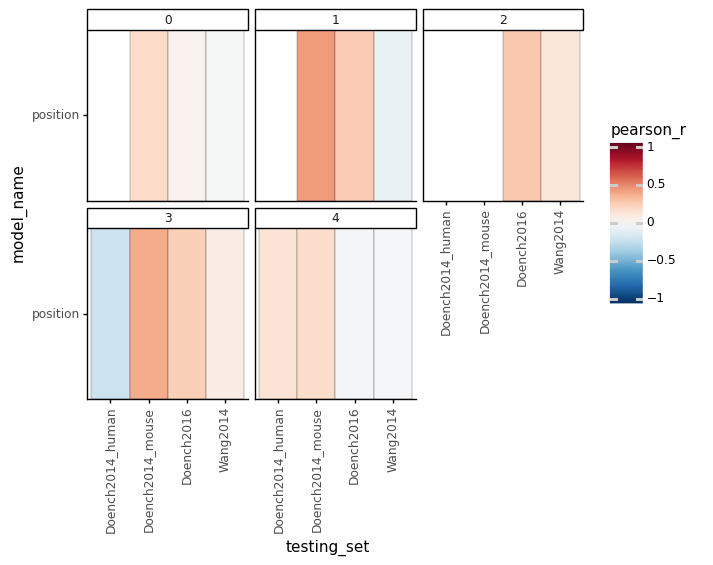

<ggplot: (8783748299463)>

In [12]:
plot_pearson_heatmap(position_predictive_performance)

On average we're performing better with positional features, but not across every dataset

In [13]:
position_predictive_performance['pearson_r'].agg(['mean', 'median'])

mean      0.123974
median    0.128461
Name: pearson_r, dtype: float64